In [17]:
from ggplot import *
import pandas as pd
import json
import pickle
from sklearn.cluster import KMeans
import nltk
import language_check
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.decomposition import PCA
# nltk.download('wordnet')

Подкачиваем файл с текстами ревью пользователей и файлы с продуктами

In [2]:
with open('reviews_Books_5.json') as f:
    data = pd.DataFrame(json.loads(line) for i, line in enumerate(f) if json.loads(line)['unixReviewTime'] < 1167609600)

In [13]:
PATH = "package"
files = list(os.walk(PATH))[0][2]
df_products_to_rev = pd.read_csv('//'.join((PATH, files[0])))
df_products = pd.read_csv('//'.join((PATH, files[1])), escapechar='\\', quotechar='"')
df_products_to_categories = pd.read_csv('//'.join((PATH, files[2])))

Приводим датафрейм к нужному виду

In [15]:
data['reviewTime'] = pd.to_datetime(data['reviewTime'], format='%m %d, %Y')
data['group'] = data.asin.astype(str) + '_' + data.reviewerID.astype(str) + '_' + data.reviewTime.astype(str)
text_dict = {x:y for x, y in zip(data.group.tolist(), data.reviewText.tolist())}

Совмещаем датасеты

In [8]:
category = [x.split(';')[2] for x in df_products_to_categories.category_ids.tolist()]
category_dict = {x:y for x, y in zip(df_products_to_categories.id.tolist(), category)}

In [9]:
df_products_to_rev['category'] = df_products_to_rev.productId.map(category_dict)
id_asin = {x:y for x, y in zip(df_products.id.tolist(), df_products.asin.tolist())}
df_products_to_rev['asin'] = df_products_to_rev.productId.map(id_asin)
df_products_to_rev['date'] = pd.to_datetime(df_products_to_rev['date'], format='%Y-%m-%d')
df_products_to_rev['group'] = df_products_to_rev.asin.astype(str) + '_' + df_products_to_rev.customer.astype(str) + '_' + df_products_to_rev.date.astype(str)
df_products_to_rev['text'] = df_products_to_rev.group.map(text_dict)

Дропаем продукты на которых не ревью

In [15]:
drop_index = df_products_to_rev['text'][df_products_to_rev['text'].isnull()].index
new_df_products_to_rev = df_products_to_rev.drop(drop_index, axis = 0)
new_df_products_to_rev.index = range(len(new_df_products_to_rev))
new_df_products_to_rev['len_text'] = [len(x) for x in new_df_products_to_rev.text.tolist()]
new_df_products_to_rev['customer_category'] = new_df_products_to_rev.customer.astype(str) + '_' + new_df_products_to_rev.category.astype(str)

Создаем новый датасет, который мы будем использовать для кластеризации пользователей и добавляем среднюю длину текста

In [169]:
train_data = pd.DataFrame()

alpha = 10
customer_mean = new_df_products_to_rev.groupby('customer')['len_text'].mean().to_dict()
k = new_df_products_to_rev.groupby('customer')['len_text'].count().to_dict()
global_mean = new_df_products_to_rev['len_text'].mean()

ids = []
len_text_mean = []
for key in customer_mean:
    ids += [key]
    len_text_mean += [(k[key] * customer_mean[key] + alpha * global_mean) / (k[key] + alpha)]
    
train_data['customer'] = ids
train_data['len_text_mean'] = len_text_mean

Добалвяем среднюю оценка для каждой из подкатегории книжек

In [170]:
customer_mean = new_df_products_to_rev.groupby(['customer','category'])['rating'].mean().to_dict()
k = new_df_products_to_rev.groupby(['customer','category'])['rating'].count().to_dict()
global_mean = new_df_products_to_rev['rating'].mean()
for cat in new_df_products_to_rev.category.unique():
    new_dict_mean = {x[0]:y for x,y in customer_mean.items() if x[1] == cat}
    new_dict_k = {x[0]:y for x,y in k.items() if x[1] == cat}
    rating_mean = []
    global_mean = new_df_products_to_rev[new_df_products_to_rev.category == cat]['rating'].mean()
    for key in train_data.customer.tolist() :
        if key in new_dict_k:
            rating_mean += [(new_dict_k[key] * new_dict_mean[key] + alpha * global_mean) / (new_dict_k[key] + alpha)]
        else:
            rating_mean += [0]
    train_data['rating_mean_' + cat] = rating_mean

Добавляем количество swear words для каждого ревью

In [127]:
swear_dict = set(['shit','fuck','damn','bitch', 'crap','piss', 'dick', 'darn', 'fag', 'pussy', 'asshole',
                 'cock', 'pussy', 'bastard','retard','slut', 'douche', 'dickhead', 'hate', 'miserable',
                 'ugly', 'moron', 'idiot','fool','shame', 'stupid', 'cretin', 'loser', 'dummy'])
lmtzr = WordNetLemmatizer()
swear_list = []
for i, x in  enumerate(new_df_products_to_rev.text.tolist()):
    if i % 10000 == 0:
        print(i)
    set_w = set()
    for w in x.split():
        set_w.add(lmtzr.lemmatize(w))
    inter = swear_dict.intersection(set_w)
    swear_list += [len(inter)]

Добавляем количество граматических ошибок для каждого ревью

In [208]:
tool = language_check.LanguageTool('en-US')
error_list1 = []
for i, x in  enumerate(new_df_products_to_rev.text.tolist()):
    if i % 10000 == 0:
        print(i)
    x = x.replace('\x03', '')
    x = x.replace('\x18', '')
    x = x.replace('\x1b', '')
    x = x.replace('\x10', '')
    matches = tool.check(x)
    error_list += [len(matches)]

In [165]:
new_df_products_to_rev['error_list'] = error_list
new_df_products_to_rev['swear_list'] = swear_list
new_df_products_to_rev['minus'] = new_df_products_to_rev['votes'] - new_df_products_to_rev['helpful']

Агригируем различные признаки по пользователям

In [171]:
alpha = 10
for col in ['error_list', 'swear_list', 'helpful', 'minus','rating']:
    customer_mean = new_df_products_to_rev.groupby('customer')[col].mean().to_dict()
    k = new_df_products_to_rev.groupby('customer')[col].count().to_dict()
    global_mean = new_df_products_to_rev[col].mean()

    ids = []
    len_text_mean = []
    for key in customer_mean:
        len_text_mean += [(k[key] * customer_mean[key] + alpha * global_mean) / (k[key] + alpha)]

    train_data[col + '_mean'] = len_text_mean

Используем Tfidf и выбираем топ 30 слов

In [179]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   ngram_range = (1,2),
                                   max_features=30,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(new_df_products_to_rev.text.tolist())

for n, x in zip(tfidf_vectorizer.get_feature_names(), tfidf.toarray().T ):
    new_df_products_to_rev[n] = x

In [193]:
for col in tfidf_vectorizer.get_feature_names():
    customer_mean = new_df_products_to_rev.groupby('customer')[col].mean().to_dict()
    k = new_df_products_to_rev.groupby('customer')[col].count().to_dict()
    global_mean = new_df_products_to_rev[col].mean()

    ids = []
    len_text_mean = []
    for key in customer_mean:
        len_text_mean += [(k[key] * customer_mean[key] + alpha * global_mean) / (k[key] + alpha)]

    train_data[col + '_mean'] = len_text_mean

In [2]:
# train_data.to_csv('train_data.csv', index = None)

# with open('asin.pickle','wb') as f:
#     pickle.dump(new_df_products_to_rev.asin.tolist(), f)
    
# with open('customer.pickle','wb') as f:
#     pickle.dump(train_data.customer.tolist(), f)
    
# with open('productId.pickle','wb') as f:
#     pickle.dump(new_df_products_to_rev.productId.tolist(), f)

# with open('new_df_products_to_rev.pickle','wb') as f:
#     pickle.dump(new_df_products_to_rev, f)

# train_data = pd.read_csv('train_data.csv')

Делаем кластеризацию пользователей с помощью KMeans

In [5]:
train_data = train_data.drop(['customer'], axis  = 1)
kmeans = KMeans(6).fit(train_data)

Посмотрим ключевые характеристики для каждого из кластеров

In [19]:
need_ind = []
for x in range(6):
    need_ind += [[i for i, y in enumerate(kmeans.labels_) if y == x]]

for x in range(6):
    print('Cluster: ' + str(x + 1))
    print('number ' + str(len(need_ind[x])))
    print(train_data.loc[need_ind[x],'swear_list_mean'].mean(), 'swear_words')
    print(train_data.loc[need_ind[x],'helpful_mean'].mean(), 'helpful')
    print(train_data.loc[need_ind[x],'error_list_mean'].mean(), 'error in review')
    print(train_data.loc[need_ind[x],'len_text_mean'].mean(), 'len_review')
    print(train_data.loc[need_ind[x],'minus_mean'].mean(), 'minus')
    print(train_data.loc[need_ind[x],'rating_mean'].mean(), 'rating')
    print('------------')

Cluster: 1
number 16813
0.04803672340491827 swear_words
7.001108682487367 helpful
10.776212759121263 error in review
1191.2804458753012 len_review
2.3199371624973004 minus
4.155871077448133 rating
------------
Cluster: 2
number 1837
0.06032868280379191 swear_words
8.276768155289126 helpful
14.293966439666912 error in review
1558.2736576106736 len_review
2.5108529118538403 minus
4.143847161932269 rating
------------
Cluster: 3
number 518
0.07031728119820586 swear_words
9.101063880828908 helpful
18.408570209953165 error in review
1993.3315450562989 len_review
2.6777190503291965 minus
4.155294199419021 rating
------------
Cluster: 4
number 3548
0.042169753874581294 swear_words
6.375868733857006 helpful
9.338436894294526 error in review
1028.5786627579137 len_review
2.285625628702093 minus
4.166455986605261 rating
------------
Cluster: 5
number 99
0.09498774852893149 swear_words
10.083111201975052 helpful
25.365497754723272 error in review
2913.3871469759933 len_review
2.7576270550839252 m

Можем заметить что в пятом кластере находятся самые агрессивные пользователи, у которых имеются проблемы с грамматикой. При этом их средняя оценка книге больше, чем среди всех остальных классов. Аналогичная ситуации обстоит со вторым кластером.

1 и 4 кластер используют меньше слов в своих ревью и в следствии этого и имеют меньше грамматических ошибок. Но и лайков их ревью получают меньше. Поэтому вся слава достаётся дерзким людям.

Для визуализации используем PCA

In [10]:
df = PCA(n_components = 2).fit_transform(train_data)
df = pd.DataFrame({'pca-one':df[:,0], 'pca-two':df[:,1], 'label':kmeans.labels_})

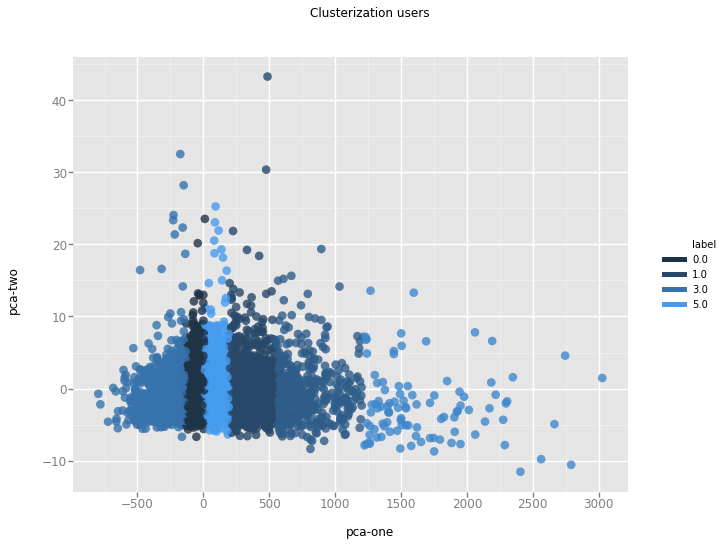

<ggplot: (42172905059)>

In [11]:
chart = ggplot( df, aes(x='pca-one', y='pca-two', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("Clusterization users")
chart